In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
from joblib import dump
from IPython.display import IFrame
import tempfile
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')
# import dask.dataframe as dd


In [100]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp1"
os.makedirs(save_dir, exist_ok=True)

In [101]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_days_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_days_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_days_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_test_train_lag{ndays}_days_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_days_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_test_train_lag{ndays}_days_pre_processing.csv', index_col=None)
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))

In [102]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(67714, 93) (67714, 1) (45368, 93) (45368, 1) (22346, 93) (22346, 1)


### Analyze the regression relation

#### Use OLS regression

In [103]:
def analyze_OLS(x,y):
    x = sm.add_constant(x)  
    model = sm.OLS(y, x,hasconst=True)
    results = model.fit()
    summary = results.summary()
    # print(summary)
    return summary
print(analyze_OLS(X,y))

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     839.3
Date:                Sat, 06 Jul 2024   Prob (F-statistic):               0.00
Time:                        08:27:38   Log-Likelihood:                -70797.
No. Observations:               67714   AIC:                         1.418e+05
Df Residuals:                   67621   BIC:                         1.426e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

#### Use Linear machine learning model

In [104]:
def print_sorted_coefficients(model, model_name, feature_names):
    coef = model.coef_
    if len(coef.shape) > 1:
        coef = coef[0]
    sorted_indices = np.argsort(-np.abs(coef))  
    sorted_coef = coef[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    for i, (name, value) in enumerate(zip(sorted_feature_names, sorted_coef)):
        print(f"{model_name} Coefficient {i + 1}: {name}, Coefficient: {value}")

In [105]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_valid)

print_sorted_coefficients(linear_model, "Linear Regression", X_train.columns)
print("Linear Regression intercept:", linear_model.intercept_)





Linear Regression Coefficient 1: shortwave_radiation_hl_7d, Coefficient: 109659.04461116756
Linear Regression Coefficient 2: direct_solar_radiation_hl_7d, Coefficient: -84935.45589471757
Linear Regression Coefficient 3: shortwave_radiation, Coefficient: -54893.55561482054
Linear Regression Coefficient 4: direct_solar_radiation_hd_7d, Coefficient: 41902.932255203115
Linear Regression Coefficient 5: diffuse_radiation_hl_7d, Coefficient: -34344.35826822392
Linear Regression Coefficient 6: diffuse_radiation, Coefficient: 16451.973714676933
Linear Regression Coefficient 7: installed_capacity, Coefficient: 1.004988965619509
Linear Regression Coefficient 8: eic_count, Coefficient: -0.4779838680688611
Linear Regression Coefficient 9: is_consumption, Coefficient: 0.376967697398891
Linear Regression Coefficient 10: temperature_hl_7d, Coefficient: 0.09000301018287951
Linear Regression Coefficient 11: temperature, Coefficient: 0.07038784686908951
Linear Regression Coefficient 12: temperature_hd_7d

In [106]:
print("Linear Regression R²:", r2_score(y_valid, y_pred_linear))
print("Linear Regression MAE:", mean_absolute_error(y_valid, y_pred_linear))

Linear Regression R²: 0.5308897529505401
Linear Regression MAE: 0.33154327852900006


In [107]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_valid)



print_sorted_coefficients(ridge_model, "Ridge Regression", X_train.columns)
print("Ridge Regression intercept:", ridge_model.intercept_)







Ridge Regression Coefficient 1: installed_capacity, Coefficient: 1.0048618476601765
Ridge Regression Coefficient 2: eic_count, Coefficient: -0.4778713262089479
Ridge Regression Coefficient 3: is_consumption, Coefficient: 0.37693454970449136
Ridge Regression Coefficient 4: temperature_hl_7d, Coefficient: 0.08718460189695301
Ridge Regression Coefficient 5: temperature, Coefficient: 0.06562034302613753
Ridge Regression Coefficient 6: cos(dayofyear), Coefficient: 0.06353166071598336
Ridge Regression Coefficient 7: temperature_fl_7d, Coefficient: -0.06279773110982285
Ridge Regression Coefficient 8: temperature_hd_7d, Coefficient: -0.05890236500345047
Ridge Regression Coefficient 9: temperature_fd_7d, Coefficient: 0.04961991142420694
Ridge Regression Coefficient 10: dewpoint_hl_7d, Coefficient: -0.047493914516535396
Ridge Regression Coefficient 11: direct_solar_radiation, Coefficient: 0.03958056134894724
Ridge Regression Coefficient 12: temperature_fl, Coefficient: -0.03955559885039646
Ridge

In [108]:
print("Ridge Regression R²:", r2_score(y_valid, y_pred_ridge))
print("Ridge Regression MAE:", mean_absolute_error(y_valid, y_pred_ridge))

Ridge Regression R²: 0.5309162144772899
Ridge Regression MAE: 0.33152014777328115


### Build Decision Tree and Improve in valid set

In [47]:
dt_model = DecisionTreeRegressor(random_state=42, **best_params['dt_grid_search'].item())
dt_model.fit(X_train, y_train)
dump(dt_model, f'{save_dir}/dt_model_tuning.joblib')



['../../exps/exp1/dt_model_tuning.joblib']

In [48]:
dt_valid_predictions = dt_model.predict(X_valid)
dt_valid_mae = mean_absolute_error(y_valid, dt_valid_predictions)
dt_valid_r2 = r2_score(y_valid, dt_valid_predictions)
print(f"Decision Tree - Validation MAE: {dt_valid_mae:.3f}, Validation R2: {dt_valid_r2:.3f}")


Decision Tree - Validation MAE: 0.119, Validation R2: 0.900


In [49]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [50]:
print("Feature ranking:")
for i, index in enumerate(indices):
    print(f"{i + 1}. feature {X.columns[index]} ({importances[index]})")

Feature ranking:
1. feature installed_capacity (0.47938242346702287)
2. feature segment (0.39445400001587666)
3. feature surface_solar_radiation_downwards_fl (0.030901910454612172)
4. feature is_consumption (0.02422149482589443)
5. feature is_business (0.017473572380747104)
6. feature prediction_unit_id (0.007261009549714078)
7. feature eic_count (0.0041390404390381575)
8. feature data_block_id_right (0.0036295254210616276)
9. feature surface_solar_radiation_downwards (0.003309682057961776)
10. feature cos(dayofyear) (0.002898343283171862)
11. feature direct_solar_radiation_hd_7d (0.0026437449432877265)
12. feature direct_solar_radiation (0.0018565859632250826)
13. feature county (0.0017655303892496956)
14. feature direct_solar_radiation_fl (0.0013260470097545428)
15. feature euros_per_mwh (0.001083585373572907)
16. feature cloudcover_low_fl (0.0008698027366507929)
17. feature temperature_fd_7d (0.0008533790494214014)
18. feature winddirection_10m (0.0008385637356733224)
19. feature lo

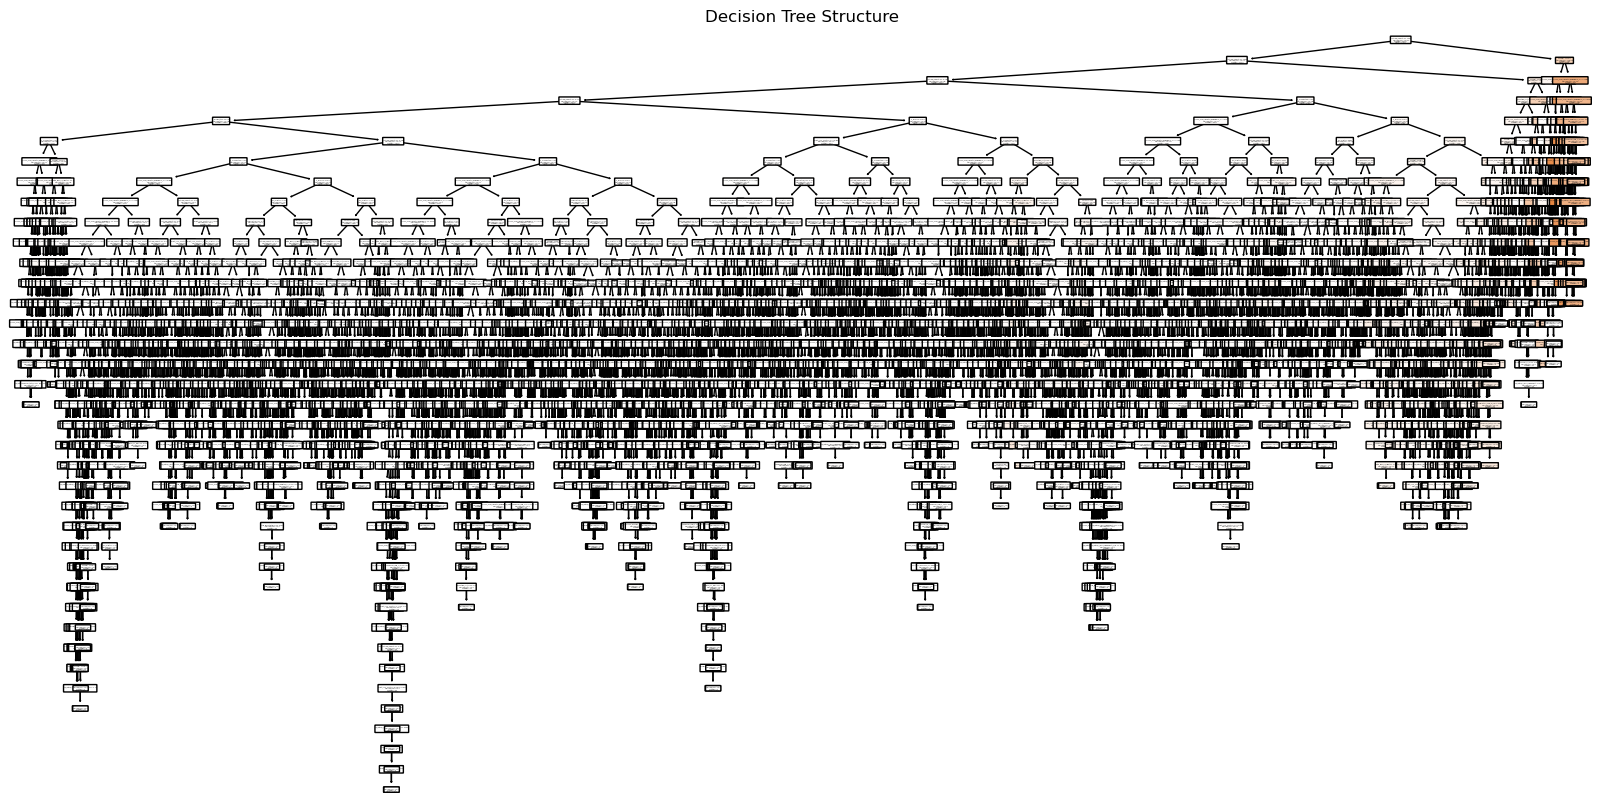

In [51]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

### Use LIME, SHAP to explained

 99%|===================| 22112/22346 [00:13<00:00]        

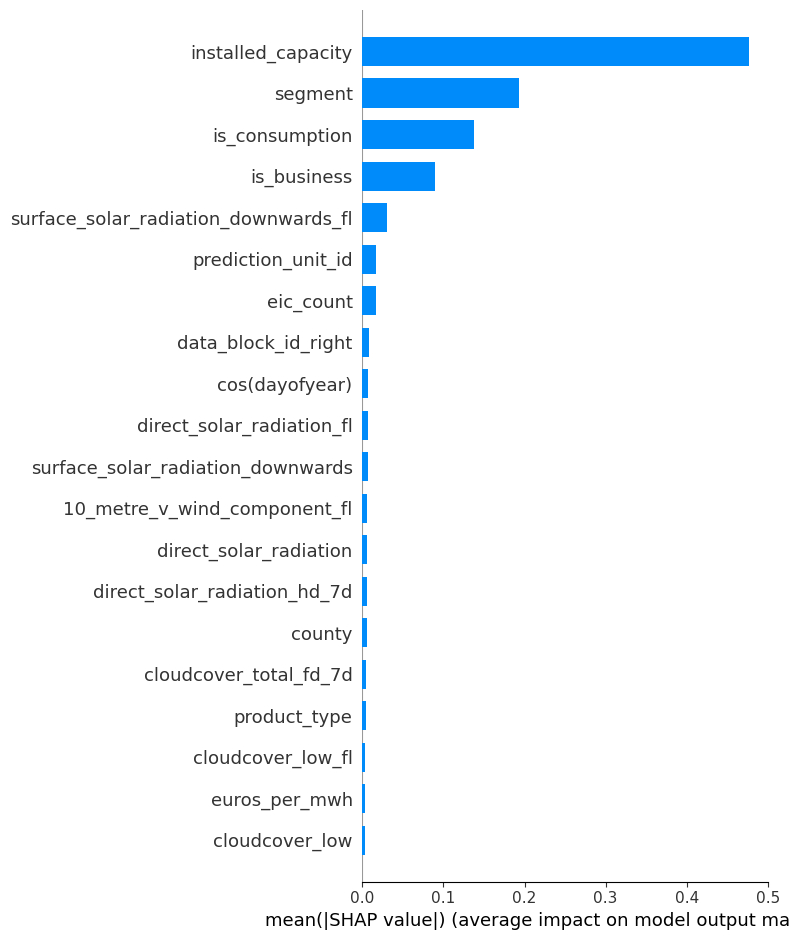

In [52]:
explainer_dt = shap.Explainer(dt_model, X_train)
shap_values_dt = explainer_dt(X_valid, check_additivity=False)


shap.summary_plot(shap_values_dt, X_valid, plot_type="bar", title="SHAP Decision Tree Feature Importance")


In [53]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_dt = explainer.explain_instance(X_valid.iloc[0].values, dt_model.predict)
file_name = f"{save_dir}/lime_explanation_dt.html"

lime_exp_dt.save_to_file(file_name)
lime_exp_dt.show_in_notebook()


### Build LGBM and Improve in valid set

In [54]:
lgbm_model = lgb.LGBMRegressor(objective='regression',**best_params['lgb_grid_search'].item())
lgbm_model.fit(X_train, y_train)
dump(lgbm_model, f'{save_dir}/lgbm_model_tuning.joblib')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21293
[LightGBM] [Info] Number of data points in the train set: 45368, number of used features: 93
[LightGBM] [Info] Start training from score -0.025777


['../../exps/exp1/lgbm_model_tuning.joblib']

In [55]:
lgbm_model_predictions = lgbm_model.predict(X_valid)
lgbm_model_mae = mean_absolute_error(y_valid, lgbm_model_predictions)
lgbm_model_r2 = r2_score(y_valid, lgbm_model_predictions)
print(f"LGBM model - Validation MAE: {lgbm_model_mae:.3f}, Validation R2: {lgbm_model_r2:.3f}")

LGBM model - Validation MAE: 0.118, Validation R2: 0.904


### Use LIME, SHAP to explained

 99%|===================| 22200/22346 [01:50<00:00]        

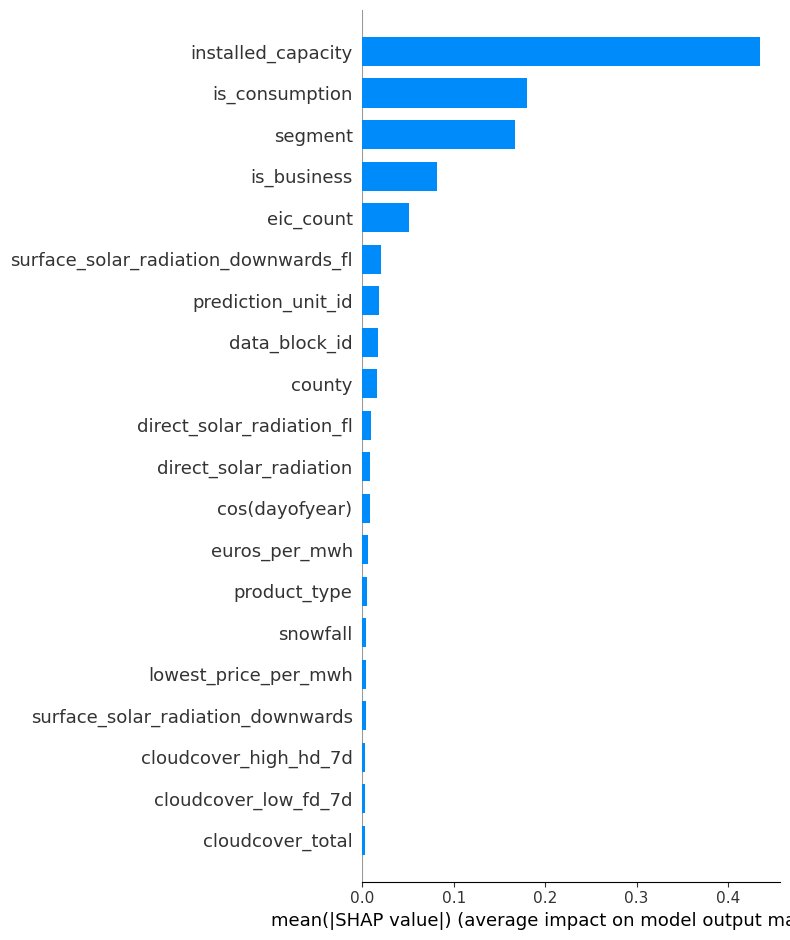

In [56]:
explainer_lgbm = shap.Explainer(lgbm_model, X_train)
shap_values_lgbm = explainer_lgbm(X_valid, check_additivity=False)


shap.summary_plot(shap_values_lgbm, X_valid, plot_type="bar", title="SHAP LGBM Feature Importance")



In [57]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_lgbm = explainer.explain_instance(X_valid.iloc[0].values, lgbm_model.predict)
file_name = f"{save_dir}/lime_explanation_lgbm.html"

lime_exp_lgbm.save_to_file(file_name)
lime_exp_lgbm.show_in_notebook()


### Build Random Forest and Improve in valid set

In [58]:
rf= RandomForestRegressor(random_state=42, **best_params['rf_grid_search'].item())
rf.fit(X_train, y_train)
dump(rf, f'{save_dir}/rf_model_tuning.joblib')


['../../exps/exp1/rf_model_tuning.joblib']

In [59]:
rf_predictions = rf.predict(X_valid)
rf_mae = mean_absolute_error(y_valid, rf_predictions)
rf_r2 = r2_score(y_valid, rf_predictions)
print(f"Random Forest- Validation MAE: {rf_mae:.3f}, Validation R2: {rf_r2:.3f}")

Random Forest- Validation MAE: 0.104, Validation R2: 0.924


### Use LIME, SHAP to explained

100%|===================| 22340/22346 [40:29<00:00]        

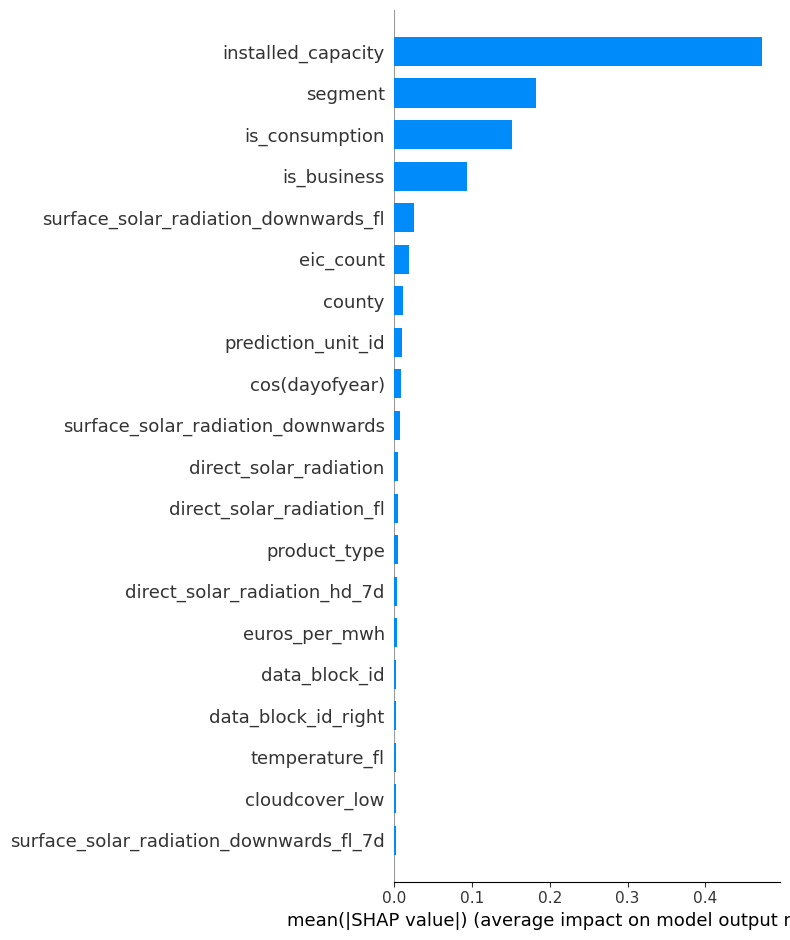

In [60]:
explainer_rf = shap.Explainer(rf, X_train)
shap_values_rf = explainer_rf(X_valid, check_additivity=False)


shap.summary_plot(shap_values_rf, X_valid, plot_type="bar", title="SHAP rf Feature Importance")



In [61]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)
lime_exp_rf = explainer.explain_instance(X_valid.iloc[0].values, rf.predict)
file_name = f"{save_dir}/lime_explanation_rf.html"

lime_exp_rf.save_to_file(file_name)
lime_exp_rf.show_in_notebook()
